In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import spline

import ROOT
from ROOT import gROOT, gSystem, TFile, TGraphAsymmErrors, TH1, TF1, TFitResultPtr
import rootnotes
import rootprint

import plottingFunctions as pF
from astropy import units as u


default colormap is now ds9b


You are giving the normalization at 1.000
Yet the decorrelation energy is at  0.218
You might consider updating your normalization energy and rerunning.
You are giving the normalization at 1.000
Yet the decorrelation energy is at  0.191
You might consider updating your normalization energy and rerunning.


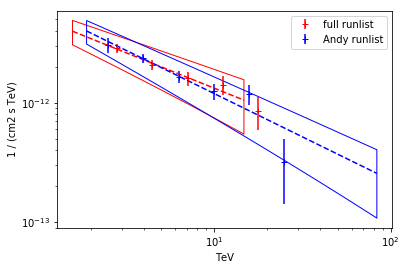

In [2]:
home = os.path.expanduser("~")
filename = home + "/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root"
spectrum = pF.spectrumPlotter()
spectrum.ReadVEGASs6Root(filename)
spectrum.plotSpectrum(label="full runlist") #xmin=0.1
spectrum.ReadVEGASs6Root(home+"/VERITAS/GC/results/stage6_Andy_SgrA_spectrum_SgrA_s6.root")
spectrum.plotSpectrum(label="Andy runlist", c='blue')



In [3]:
print spectrum.energyUnits.to_string()
energyUnits = u.TeV
sedUnits = (energyUnits * u.s**-1 * u.cm * u.cm)
print sedUnits.to_string()

TeV
cm2 TeV / s


In [4]:
%%rootprint
vegasPath = os.path.expandvars("$VEGAS")
#vegasPath = "/home/mbuchove/Downloads"

# test with ROOT6
#gROOT.Reset()
gSystem.Load("libTreePlayer.so")
gSystem.Load("libPhysics.so")
gSystem.Load(vegasPath + "/common/lib/libSP24sharedLite.so")
gSystem.Load(vegasPath + "/resultsExtractor/lib/libStage6shared.so")
gSystem.AddIncludePath("-Wno-unused -Wno-shadow -Wno-unused-parameter")
gROOT.ProcessLine(".L " + vegasPath + "/common/include/VACommon.h")
gROOT.ProcessLine(".include " + vegasPath + "/common/include/")
gROOT.ProcessLine(".include " + vegasPath + "/resultsExtractor/include/")
gROOT.ProcessLine(".include " + vegasPath + "/cfitsio/include/")
    

#vacomm = VASpectrumAnl()
    
try:
    vegas_class = VACommon()
except:
    print "Unexpected error:", sys.exc_info()[0]
    _use_vegas = False
else:
    _use_vegas = True
    
    
print _use_vegas


Unexpected error: <type 'exceptions.NameError'>
False
reloading /home/mbuchove/VERITAS/base-ROOT5/VEGAS-v255/common/include/VACommon.h  0
reloading VAUsefulConversions.h  0
reloading cfloat  0
reloading float.h  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/TArchiveFile/P010_TZIPFile.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/TVirtualStreamerInfo/P010_TStreamerInfo.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P010_Minuit2Minimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P020_TMinuitMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P030_GSLMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P040_GSLNLSMinimizer.C  0
reloading /home/mbuchove/VERITAS/base-ROOT5/ROOT-install/etc/plugins/ROOT@@Math@@Minimizer/P050_GSLSimAn

In [5]:
home = os.path.expanduser("~")
filename = home + "/VERITAS/GC/results/SgrA_disp5t_v255_okay-obs-4tel_medium_both_s6.root"
s6F = TFile(filename, "read")
if not s6F.IsOpen():
    print "Failure!"
specAn = s6F.Get("Spectrum/VASpectrumAnl")
hMM = s6F.Get("Spectrum/hMigrationMatrix")
hFEH = s6F.Get("Spectrum/hFullExcessHist")
RBM = s6F.Get("RingBackgroundModelAnalysis")

specHist = specAn.GetSpectrumHist()
rebinned_specHist = specAn.GetRebinnedSpectrumHist()
specGraph = specAn.GetSpectrumGraph()



SystemError: problem in C++; program state has been reset

In [ ]:
xaxis = specGraph.GetXaxis()
alpha = specAn.GetAlphaHist()
sig = specAn.GetSigmaHist()

In [ ]:
type(specAn)
TFile.Open("gyih")
#sa = __main__.VASpectrumAnl()
arr = np.array((0,))
print arr[0]

In [ ]:
def get_hist_points(h):
    """return E[TeV], flux[1/TeV*m^2*s], and flux_err as lists"""
    x, y, yerr = [], [], []
    for pt in range(1, h.GetNbinsX()+1):
        tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
        #h.GetPoint(pt, tmpX, tmpY)
        x.append(h.GetBinCenter(pt))
        y.append(h.GetBinContent(pt))
        yerr.append(h.GetBinError(pt))
        
    #print np.array(x), np.array(y), np.array(yerr)
    return np.power(10, np.array(x)), np.array(y), np.array(yerr)
# get_hist_points



In [ ]:
xlab = specHist.GetXaxis().GetTitle()
ylab = specHist.GetYaxis().GetTitle()
print xlab

E, flux, flux_err = get_hist_points(rebinned_specHist)
print E
print flux
print flux_err

print type(specGraph)

In [ ]:
#%%rootprint
tf1 = specGraph.GetFunction("fFitFunction")
fitnorm = tf1.GetParameter(0)
fitindex = tf1.GetParameter(1)
normenergy = tf1.GetParameter(2)

r = specGraph.Fit(tf1, "S") #TFitResultPtr
#for i in range(3):
#    print tf1.GetParameter(i)
    
cov = r.GetCovarianceMatrix() #TMatrixTSym<double>
cov.Print()

var_norm = cov(0, 0)
var_index = cov(1, 1)
cov_normindex = cov(0, 1) # == (1, 0)

print np.sqrt(var_norm)
print np.sqrt(var_index)
print cov_normindex

#covarr = cov.GetMatrixArray()


In [ ]:
npoints     = specGraph.GetN()

x2, y2 = [], []
y_err = []
for i in range(npoints):
    tmpX, tmpY = ROOT.Double(0), ROOT.Double(0)
    specGraph.GetPoint(i, tmpX, tmpY)
    x2.append(tmpX)
    y2.append(tmpY)
    y_err.append((specGraph.GetErrorYlow(i), specGraph.GetErrorYhigh(i)))
    
x2 = np.array(x2)
y2 = np.array(y2)
y_err = np.array(y_err)

print x2
print y2
print y_err

In [ ]:
%%rootprint
s6F.ls()
cov.Print()


In [ ]:
num = 9
type(num)

tels = 0 
for i in range(4):
    if num >> i & 1:
        tels += 1

print tels